In [8]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
fake = Faker()
fake.seed(12345)
random.seed(12345)

EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']

# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

def load_date():
    """
        Loads some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, examples=EXAMPLES):
    predicted = []
    for example in examples:
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        print('output:', predicted[-1])
    return predicted


def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        

def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

In [11]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6164.69it/s]


Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [12]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

def one_step_attention(a, s_prev):

    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    
    return context

In [13]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):

    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    a = Bidirectional(LSTM(n_a, return_sequences = True))(X)
    
    for t in range(Ty):
    
        context =  one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    return model

In [14]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

In [15]:
opt = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer =opt, metrics = ['accuracy'] )

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1


 1600/10000 [===>..........................] - ETA: 1:14:58 - loss: 24.0167 - dense_9_loss_1: 2.4043 - dense_9_loss_2: 2.3955 - dense_9_loss_3: 2.4053 - dense_9_loss_4: 2.3977 - dense_9_loss_5: 2.4027 - dense_9_loss_6: 2.4013 - dense_9_loss_7: 2.3972 - dense_9_loss_8: 2.4046 - dense_9_loss_9: 2.4135 - dense_9_loss_10: 2.3946 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.0000e+00 - dense_9_acc_3: 0.0000e+00 - dense_9_acc_4: 0.1100 - dense_9_acc_5: 0.0300 - dense_9_acc_6: 0.0000e+00 - dense_9_acc_7: 0.1200 - dense_9_acc_8: 0.0300 - dense_9_acc_9: 0.0000e+00 - dense_9_acc_10: 0.110 - ETA: 37:36 - loss: 23.8797 - dense_9_loss_1: 2.3972 - dense_9_loss_2: 2.3941 - dense_9_loss_3: 2.4027 - dense_9_loss_4: 2.4008 - dense_9_loss_5: 2.3564 - dense_9_loss_6: 2.3791 - dense_9_loss_7: 2.4008 - dense_9_loss_8: 2.3505 - dense_9_loss_9: 2.3960 - dense_9_loss_10: 2.4021 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.0000e+00 - dense_9_acc_3: 0.0000e+00 - dense_9_acc_4: 0.0550 - dense_9_acc_5: 0.5150 -

 3200/10000 [========>.....................] - ETA: 4:28 - loss: 22.1521 - dense_9_loss_1: 2.2646 - dense_9_loss_2: 2.2507 - dense_9_loss_3: 2.3842 - dense_9_loss_4: 2.5890 - dense_9_loss_5: 1.7079 - dense_9_loss_6: 1.8759 - dense_9_loss_7: 2.6209 - dense_9_loss_8: 1.6245 - dense_9_loss_9: 2.0718 - dense_9_loss_10: 2.7626 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.0000e+00 - dense_9_acc_3: 0.0035 - dense_9_acc_4: 0.0200 - dense_9_acc_5: 0.7782 - dense_9_acc_6: 0.1429 - dense_9_acc_7: 0.0300 - dense_9_acc_8: 0.6565 - dense_9_acc_9: 0.0871 - dense_9_acc_10: 0.04 - ETA: 4:12 - loss: 22.0846 - dense_9_loss_1: 2.2607 - dense_9_loss_2: 2.2335 - dense_9_loss_3: 2.3797 - dense_9_loss_4: 2.5974 - dense_9_loss_5: 1.6837 - dense_9_loss_6: 1.8670 - dense_9_loss_7: 2.6257 - dense_9_loss_8: 1.5995 - dense_9_loss_9: 2.0673 - dense_9_loss_10: 2.7700 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.0000e+00 - dense_9_acc_3: 0.0033 - dense_9_acc_4: 0.0189 - dense_9_acc_5: 0.7906 - dense_9_acc_6: 0.135

 4800/10000 [=============>................] - ETA: 2:10 - loss: 21.3623 - dense_9_loss_1: 2.2117 - dense_9_loss_2: 1.9350 - dense_9_loss_3: 2.2799 - dense_9_loss_4: 2.7521 - dense_9_loss_5: 1.4983 - dense_9_loss_6: 1.7404 - dense_9_loss_7: 2.6990 - dense_9_loss_8: 1.4747 - dense_9_loss_9: 1.9992 - dense_9_loss_10: 2.7721 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.2312 - dense_9_acc_3: 0.0927 - dense_9_acc_4: 0.0303 - dense_9_acc_5: 0.8488 - dense_9_acc_6: 0.0864 - dense_9_acc_7: 0.0158 - dense_9_acc_8: 0.8076 - dense_9_acc_9: 0.0552 - dense_9_acc_10: 0.03 - ETA: 2:06 - loss: 21.3164 - dense_9_loss_1: 2.2110 - dense_9_loss_2: 1.9145 - dense_9_loss_3: 2.2703 - dense_9_loss_4: 2.7616 - dense_9_loss_5: 1.4864 - dense_9_loss_6: 1.7333 - dense_9_loss_7: 2.7032 - dense_9_loss_8: 1.4729 - dense_9_loss_9: 1.9948 - dense_9_loss_10: 2.7685 - dense_9_acc_1: 0.0000e+00 - dense_9_acc_2: 0.2403 - dense_9_acc_3: 0.1012 - dense_9_acc_4: 0.0324 - dense_9_acc_5: 0.8462 - dense_9_acc_6: 0.0879 - dens

 6400/10000 [==================>...........] - ETA: 1:16 - loss: 20.5207 - dense_9_loss_1: 2.0717 - dense_9_loss_2: 1.6537 - dense_9_loss_3: 2.1211 - dense_9_loss_4: 2.8275 - dense_9_loss_5: 1.3451 - dense_9_loss_6: 1.6725 - dense_9_loss_7: 2.7261 - dense_9_loss_8: 1.4393 - dense_9_loss_9: 1.9294 - dense_9_loss_10: 2.7345 - dense_9_acc_1: 0.0616 - dense_9_acc_2: 0.3927 - dense_9_acc_3: 0.1908 - dense_9_acc_4: 0.0502 - dense_9_acc_5: 0.8386 - dense_9_acc_6: 0.0914 - dense_9_acc_7: 0.0204 - dense_9_acc_8: 0.7555 - dense_9_acc_9: 0.1361 - dense_9_acc_10: 0.06 - ETA: 1:14 - loss: 20.4709 - dense_9_loss_1: 2.0586 - dense_9_loss_2: 1.6394 - dense_9_loss_3: 2.1144 - dense_9_loss_4: 2.8317 - dense_9_loss_5: 1.3338 - dense_9_loss_6: 1.6708 - dense_9_loss_7: 2.7310 - dense_9_loss_8: 1.4347 - dense_9_loss_9: 1.9260 - dense_9_loss_10: 2.7305 - dense_9_acc_1: 0.0728 - dense_9_acc_2: 0.4022 - dense_9_acc_3: 0.1932 - dense_9_acc_4: 0.0504 - dense_9_acc_5: 0.8416 - dense_9_acc_6: 0.0896 - dense_9_acc_

 8000/10000 [=======================>......] - ETA: 44s - loss: 19.6163 - dense_9_loss_1: 1.8392 - dense_9_loss_2: 1.4366 - dense_9_loss_3: 1.9719 - dense_9_loss_4: 2.8380 - dense_9_loss_5: 1.2362 - dense_9_loss_6: 1.6002 - dense_9_loss_7: 2.7568 - dense_9_loss_8: 1.3807 - dense_9_loss_9: 1.8859 - dense_9_loss_10: 2.6707 - dense_9_acc_1: 0.2035 - dense_9_acc_2: 0.5135 - dense_9_acc_3: 0.2431 - dense_9_acc_4: 0.0578 - dense_9_acc_5: 0.8265 - dense_9_acc_6: 0.0982 - dense_9_acc_7: 0.0255 - dense_9_acc_8: 0.7691 - dense_9_acc_9: 0.1888 - dense_9_acc_10: 0.083 - ETA: 43s - loss: 19.5673 - dense_9_loss_1: 1.8243 - dense_9_loss_2: 1.4259 - dense_9_loss_3: 1.9656 - dense_9_loss_4: 2.8366 - dense_9_loss_5: 1.2327 - dense_9_loss_6: 1.5947 - dense_9_loss_7: 2.7608 - dense_9_loss_8: 1.3784 - dense_9_loss_9: 1.8829 - dense_9_loss_10: 2.6654 - dense_9_acc_1: 0.2105 - dense_9_acc_2: 0.5194 - dense_9_acc_3: 0.2445 - dense_9_acc_4: 0.0592 - dense_9_acc_5: 0.8218 - dense_9_acc_6: 0.1009 - dense_9_acc_7

 9600/10000 [===========================>..] - ETA: 21s - loss: 18.7120 - dense_9_loss_1: 1.6033 - dense_9_loss_2: 1.2701 - dense_9_loss_3: 1.8586 - dense_9_loss_4: 2.8112 - dense_9_loss_5: 1.1256 - dense_9_loss_6: 1.5172 - dense_9_loss_7: 2.7721 - dense_9_loss_8: 1.3048 - dense_9_loss_9: 1.8477 - dense_9_loss_10: 2.6013 - dense_9_acc_1: 0.3279 - dense_9_acc_2: 0.5935 - dense_9_acc_3: 0.2701 - dense_9_acc_4: 0.0658 - dense_9_acc_5: 0.8427 - dense_9_acc_6: 0.1541 - dense_9_acc_7: 0.0326 - dense_9_acc_8: 0.7920 - dense_9_acc_9: 0.2275 - dense_9_acc_10: 0.102 - ETA: 20s - loss: 18.6459 - dense_9_loss_1: 1.5892 - dense_9_loss_2: 1.2595 - dense_9_loss_3: 1.8509 - dense_9_loss_4: 2.8082 - dense_9_loss_5: 1.1178 - dense_9_loss_6: 1.5084 - dense_9_loss_7: 2.7721 - dense_9_loss_8: 1.2982 - dense_9_loss_9: 1.8439 - dense_9_loss_10: 2.5978 - dense_9_acc_1: 0.3360 - dense_9_acc_2: 0.5983 - dense_9_acc_3: 0.2728 - dense_9_acc_4: 0.0665 - dense_9_acc_5: 0.8446 - dense_9_acc_6: 0.1633 - dense_9_acc_7

10000/10000 [==============================] - ETA: 3s - loss: 17.6050 - dense_9_loss_1: 1.4003 - dense_9_loss_2: 1.1192 - dense_9_loss_3: 1.7589 - dense_9_loss_4: 2.7530 - dense_9_loss_5: 0.9915 - dense_9_loss_6: 1.3803 - dense_9_loss_7: 2.7331 - dense_9_loss_8: 1.1570 - dense_9_loss_9: 1.7733 - dense_9_loss_10: 2.5383 - dense_9_acc_1: 0.4308 - dense_9_acc_2: 0.6537 - dense_9_acc_3: 0.2913 - dense_9_acc_4: 0.0733 - dense_9_acc_5: 0.8687 - dense_9_acc_6: 0.2734 - dense_9_acc_7: 0.0432 - dense_9_acc_8: 0.8254 - dense_9_acc_9: 0.2764 - dense_9_acc_10: 0.11 - ETA: 2s - loss: 17.5308 - dense_9_loss_1: 1.3891 - dense_9_loss_2: 1.1104 - dense_9_loss_3: 1.7529 - dense_9_loss_4: 2.7501 - dense_9_loss_5: 0.9831 - dense_9_loss_6: 1.3716 - dense_9_loss_7: 2.7276 - dense_9_loss_8: 1.1468 - dense_9_loss_9: 1.7660 - dense_9_loss_10: 2.5331 - dense_9_acc_1: 0.4364 - dense_9_acc_2: 0.6570 - dense_9_acc_3: 0.2927 - dense_9_acc_4: 0.0735 - dense_9_acc_5: 0.8700 - dense_9_acc_6: 0.2797 - dense_9_acc_7: 0

In [19]:
model.load_weights('model/model.h5')

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.reshape(source, (1, source.shape[0], source.shape[1]))
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


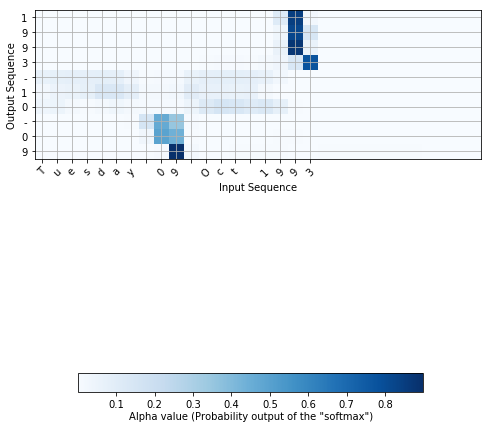

In [20]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)